  # Macroeconomics III: Problem Set 3

  Student: Rafael F. Bressan


  1. Aiyagari Model. Time is discrete and indexed by $t=0,1,2 \ldots$ Let $\beta \in(0,1)$ be the subjective discount factor, $c_{t} \geq 0$ be consumption at period $t$ and $l_{t}$ be labor supply at $t$. Agents are ex-ante identical and have the following preferences:
  Preferences:
  $$
  E_{0}\left[\sum_{t=0}^{\infty} \beta^{t}\left(\frac{c_{t}^{1-\sigma_{c}}}{1-\sigma_{c}}+\gamma \frac{\left(1-l_{t}\right)^{1-\sigma_{l}}}{1-\sigma_{l}}\right)\right]
  $$
  where $\sigma_{c}, \sigma_{l}>1, \gamma>0 .$ Expectations are taken over an idiosyncratic shock, $z_{t}$, on labor productivity, where
  $$
  \ln \left(z_{t+1}\right)=\rho \ln \left(z_{t}\right)+\epsilon_{t+1}, \quad \rho \in[0,1]
  $$
  Variable $\epsilon_{t+1}$ is an iid shock with zero mean and variance $\sigma_{\epsilon}^{2} .$ Markets are incomplete as in Huggett (1993) and Aiyagari (1994). There are no state contingent assets and agents trade a risk-free bond, $a_{t+1}$, which pays interest rate $r_{t}$ at period $t$. In order to avoid a Ponzi game assume that $a \geq 0$.

  Technology: There is no aggregate uncertainty and the technology is represented by $Y_{t}=K_{t}^{\alpha} N_{t}^{1-\alpha} .$ Let $I_{t}$ be investment at period $t .$ Capital evolves according to:
  $$
  K_{t+1}=(1-\delta) K_{t}+I_{t}
  $$
  Let $\delta=0.08, \beta=0.96, \alpha=0.4, \gamma=0.75$ and $\sigma_{c}=\sigma_{l}=2$.

  (a) Use a finite approximation for the autoregressive process
  $$
  \ln \left(z^{\prime}\right)=\rho \ln (z)+\epsilon
  $$
  where $\epsilon^{\prime}$ is normal iid with zero mean and variance $\sigma_{\epsilon}^{2} .$ Use a 7 state Markov process spanning 3 standard deviations of the log wage. Let $\rho$ be equal to $0.98$ and assume that $\sigma_{z}^{2}=\frac{\sigma_{\epsilon}^{2}}{1-\rho^{2}}=0.621 .$ Simulate this shock and report results.

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from scipy.linalg.basic import solve
# from numpy.lib.twodim_base import eye
from scipy.stats import norm
import quantecon as qe
from quantecon.markov import DiscreteDP
from numba import jit
from scipy.optimize import root
from scipy.interpolate import splev, splrep
import seaborn as sns
import time
get_ipython().run_line_magic('matplotlib', 'inline')

plt.rc('figure', figsize=(12, 6))

In [2]:
def tauchen(rho, mu, sigma_2, N, r, maxit = 1000):
    #Definindo o grid
    sigmaz_2 = sigma_2/(1-rho**2)
    z_1 = mu - r*np.sqrt(sigmaz_2)
    z_N = mu + r*np.sqrt(sigmaz_2)
    Z = np.linspace(z_1,z_N,N)
    # ~ print(Z)
    
    #Definindo os intervalos para calculo das probabilidades
    M = np.empty(N-1)
    for i in np.arange(M.size):
        M[i] = (Z[i] + Z[i+1])/2
    # ~ print(M)
    
    #Computando a Matriz de TransiÃ§Ã£o
    P = np.ones(N*N).reshape(N,N)
    # j = 1
    for i in np.arange(N):
        P[i][0] = norm.cdf((M[0]-rho*Z[i]-mu*(1-rho))/sigma_2**0.5)
    # j = N
    for i in np.arange(N):
        P[i][N-1] = 1 - norm.cdf((M[N-2]-rho*Z[i]-mu*(1-rho))/sigma_2**0.5)
    # j = 2,..,N-1
    for j in np.arange(1,N-1):
        for i in np.arange(N):
            P[i][j] = norm.cdf((M[j]-rho*Z[i]-mu*(1-rho))/sigma_2**0.5) - norm.cdf((M[j-1]-rho*Z[i]-mu*(1-rho))/sigma_2**0.5)
    # Invariant distribution
    probst0 = np.ones(N)/N
    for i in range(maxit):
        probst = P.T @ probst0
        if abs(la.norm(probst) - la.norm(probst0)) < 1e-8:
            break
        probst0 = probst.copy()
    #Retorna o grid e matriz de transiÃ§Ã£o
    return Z, P, probst



Text(0, 0.5, '$\\ln(z_t)$')

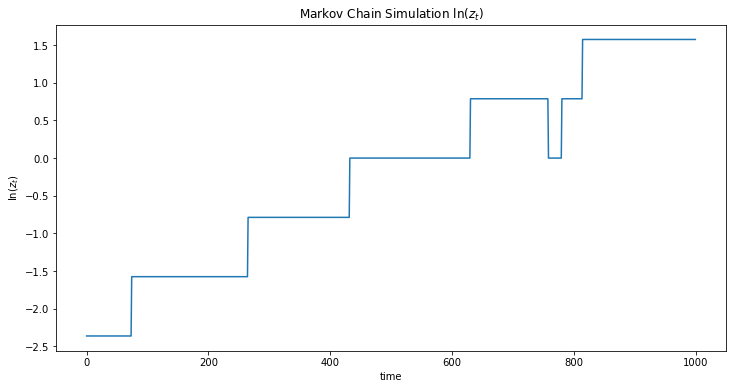

In [3]:
sigmau = np.sqrt(0.621*(1-0.98**2))
# Markov chain for ln(z)!
mc = qe.markov.approximation.tauchen(0.98, sigmau)
Tmc = 1000
fig, ax = plt.subplots()
ax.plot(np.arange(Tmc), mc.simulate(Tmc))
ax.set_title('Markov Chain Simulation $\ln(z_t)$')
ax.set_xlabel('time')
ax.set_ylabel('$\ln(z_t)$')


  (b) State the households' problem.
  Household problem is to maximize expected utility over an infinity horizon, subject to a resources constraint.

  $$
  \begin{align*}
  \max_{c_t, l_t, a_{t+1}}&E_{0}\left[\sum_{t=0}^{\infty} \beta^{t}\left(\frac{c_{t}^{1-\sigma_{c}}}{1-\sigma_{c}}+\gamma \frac{\left(1-l_{t}\right)^{1-\sigma_{l}}}{1-\sigma_{l}}\right)\right]\\
  s.t.:\, &c_t+a_{t+1}=w_t l_t z_t +(1+r_t)a_t\\
  &a_t\geq 0, \forall t
  \end{align*}
  $$

  (c) State the representative firm's problem.

  Firms will maximize their profits taking prices as given.
  $$
  \begin{align*}
  \max_{K_t, N_t}\, &K_{t}^{\alpha} N_{t}^{1-\alpha} - w_tN_t - (r_t+\delta)K_t\\
  &K_{t+1}=(1-\delta)K_t+I_t
  \end{align*}
  $$

  (d) Define the recursive competitive equilibrium for this economy.

  The stationary equilibrium is a policy function $g(k, z)$, a probability distribution $\lambda(k, z)$ and positive real numbers (K, r, w) such that:

  i) The prices (w, r) satisfy the firm's FOC:
  $$w=\partial F(K, N)/\partial N$$
  $$r=\partial F(K, N)/\partial K -\delta$$
  ii) The policy functions $k'=g(k, z)$ and $l=h(k, z)$ solve the household's problem

  iii) The probability distribution $\lambda(k, z)$ is a stationary distribution associated with the policy function and the Markov process $z_t$
  $$\lambda(k',z')=\sum_z\sum_{k:k'=g(k,z)}\lambda(k,z)\mathcal{P}(z, z')$$
  iv) The average value of capital and labor implied by the average household's decision are:
  $$
  \begin{align*}
  K=\sum_{k,z}\lambda(k,z)g(k,z)\\
  N=\sum_{k,z}\lambda(k,z)h(k,z) z
  \end{align*}
  $$
  Therefore, the recursive problem of households is:
  $$
  \begin{equation}
  V(k, z_i)=\max_{k', l}\{\left[\frac{(wlz_i+(1-\delta+r)k-k')^{1-\sigma_c}}{1-\sigma_c}+\gamma\frac{(1-l)^{1-\sigma_l}}{1-\sigma_l} \right]+\beta\sum_j P_{ij}V(k', z_j)\}
  \end{equation}
  $$

  from which we extract the policy functions $k'=g(k, z_i)$ and $l=h(k, z_i)$ for each $z_i \in Z$. And the FOCs for the firm are:
  $$
  \begin{align*}
  w&=(1-\alpha)K^\alpha N^{-\alpha}\\
  r&=\alpha K^{\alpha-1}N^{1-\alpha} - \delta
  \end{align*}
  $$
  Which in turn define $w$ in terms of $r$ and the capital-labor ration $k:=K/N$.
  $$
  \begin{align}
  r&=\alpha k^{\alpha-1}-\delta\\
  w&=(1-\alpha)
  \end{align}
  $$
  The FOCs from the household's problem gives us optimal policies for labor supply and consumption:
  $$
  \begin{align}
  l=1-c^{\frac{\sigma_c}{\sigma_l}}\left(\frac{\gamma}{wz}\right)^{1/\sigma_l}\\
  c=wzl+(1+r)a-a'
  \end{align}
  $$
  Call those optimal policies $\tilde{l}(a, z, a')$ and $\tilde{c}(a, z, a')$. Then, inserting the policies into the household's recursive problem yields a one-dimensional maximization in $a'$.


  (e) Write down a code to solve this problem. Find the policy functions for $a^{\prime}, c$, and $l$.

In [4]:
class Household:
    """
    This class takes the parameters that define a household asset accumulation
    problem and computes the corresponding reward and transition matrices R
    and Q required to generate an instance of DiscreteDP, and thereby solve
    for the optimal policy.

    Comments on indexing: We need to enumerate the state space S as a sequence
    S = {0, ..., n}.  To this end, (a_i, z_i) index pairs are mapped to s_i
    indices according to the rule

        s_i = a_i * z_size + z_i

    To invert this map, use

        a_i = s_i // z_size  (integer division)
        z_i = s_i % z_size

    """


    def __init__(self,
                r=0.01,                      # Interest rate
                w=1.0,                       # Wages
                β=0.96,                      # Discount factor
                a_min=1e-10,
                Π=[[0.9, 0.1], [0.1, 0.9]],  # Markov chain
                z_vals=[0.1, 1.0],           # Exogenous states
                a_max=18,
                a_size=80,
                sigmac=2,
                sigmal=2,
                gamma=0.75):

        # Store values, set up grids over a and z
        self.r, self.w, self.β = r, w, β
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size
        self.sigmac, self.sigmal, self.gamma = sigmac, sigmal, gamma

        self.Π = np.asarray(Π)
        self.z_vals = np.asarray(z_vals)
        self.z_size = len(z_vals)

        self.a_vals = np.linspace(a_min, a_max, a_size)
        self.n = a_size * self.z_size
        

        # Build the array Q
        self.Q = np.zeros((self.n, a_size, self.n))
        self.build_Q()

        # Build the array R
        self.R = np.empty((self.n, a_size))
        self.build_R()

    def set_prices(self, r, w):
        """
        Use this method to reset prices. Calling the method will trigger a
        re-build of R.
        """
        self.r, self.w = r, w
        self.build_R()

    def build_Q(self):
        populate_Q(self.Q, self.a_size, self.z_size, self.Π)

    def build_R(self):
        self.R.fill(-np.inf)
        populate_R(self.R,
                self.a_size,
                self.z_size,
                self.a_vals,
                self.z_vals,
                self.r,
                self.w,
                self.sigmac,
                self.sigmal,
                self.gamma)
    
    def get_hh_params(self):
        return self.sigmac, self.sigmal, self.gamma
    
class Firm():
    """Firm in an Aiyagari econony

    Returns:
        [type]: [description]
    """
    
    def __init__(self, r, alpha = 0.4, delta = 0.08, A=1) -> None:
        self.A = A
        self.alpha = alpha
        self.delta = delta
        self.r = r
    
    def output(self, K, N):
        return self.A*(K)**self.alpha*(N)**(1-self.alpha)
    
    def wage(self, r):
        a, d = self.alpha, self.delta
        return self.A*(1-a)*((self.A*a)/(r+d))**(a/(1-a))
    
    def capital_ratio(self, r):
        a, d = self.alpha, self.delta
        return ((self.A*a)/(r+d))**(1/(1-a))
    
    def rd(self, k):
        """Inverse demand of capital ratio

        Args:
            k (float): capital ratio

        Returns:
            float: interest rate associated with a given demand for k
        """
        a, d = self.alpha, self.delta
        return self.A*a*(k**(a-1))-d

# Do the hard work using JIT-ed functions

# @jit(nopython=True)
def populate_R(R, a_size, z_size, a_vals, z_vals, r, w, sigmac, sigmal, gamma):
    n = a_size * z_size
    for s_i in range(n):
        a_i = s_i // z_size
        z_i = s_i % z_size
        a = a_vals[a_i]
        z = z_vals[z_i]
        for new_a_i in range(a_size):
            a_new = a_vals[new_a_i]
            c = compute_c(w, r, a, z, a_new, sigmac, sigmal, gamma) # Compute c from NL equation
            l = compute_l(w, z, c, sigmac, sigmal, gamma)  # Compute l from intra-temporal
            if c > 0:
                R[s_i, new_a_i] = u(c, l, sigmac, sigmal, gamma)  # Utility

@jit(nopython=True)
def populate_Q(Q, a_size, z_size, Π):
    n = a_size * z_size
    for s_i in range(n):
        z_i = s_i % z_size
        for a_i in range(a_size):
            for next_z_i in range(z_size):
                Q[s_i, a_i, a_i*z_size + next_z_i] = Π[z_i, next_z_i]
                
@jit(nopython=True)
def u(c, l, sigmac, sigmal, gamma):
    return c**(1-sigmac)/(1-sigmac)+gamma*((1-l)**(1-sigmal)/(1-sigmal))


def compute_c(w, r, a, z, a_new, sigmac, sigmal, gamma):
    
    def obj_fun(c):
        e = c + c**(sigmac/sigmal)*w*z*(gamma/(w*z))**(1/sigmal)-w*z-(1+r)*a+a_new
        return e
    
    c0 = ((1+r)*a+w*z-a_new)/(1+w*z*(gamma/(w*z))**(1/sigmal)) # linear case
    res = root(obj_fun, c0)
    # Debug
    # print(f"{res.status}")
    c = res.x[0]
    return c    

def compute_l(w, z, c, sigmac, sigmal, gamma):
    return np.fmax(1 - c**(sigmac/sigmal)*(gamma/(w*z))**(1/sigmal), 0)    

@jit(nopython=True)
def asset_marginal(s_probs, a_size, z_size):
    a_probs = np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            a_probs[a_i] += s_probs[a_i*z_size + z_i]
    return a_probs

@jit(nopython=True)
def invariant_dist(s_probs, a_size, z_size):
    probs = np.zeros((z_size, a_size))
    for a_i in range(a_size):
        for z_i in range(z_size):
            probs[z_i, a_i] = s_probs[a_i*z_size + z_i]
    return probs

def get_equilibrium(hh, fm, r_eq):
    w_eq = fm.wage(r_eq)
    hh.set_prices(r_eq, w_eq)
    hh_ddp = DiscreteDP(hh.R, hh.Q, hh.β)
    # Solve using policy function iteration
    results = hh_ddp.solve(method='policy_iteration')
    # Compute the stationary distribution
    stationary_probs = results.mc.stationary_distributions[0]
    # Extract the invariant distribution
    inv_dist = invariant_dist(stationary_probs, hh.a_size, hh.z_size)
    # Simplify names
    z_size, a_size = hh.z_size, hh.a_size
    z_vals, a_vals = hh.z_vals, hh.a_vals
    n = a_size * z_size
    sigmac, sigmal, gamma = hh.get_hh_params()
    # Get all optimal actions across the set of a indices with z fixed in each ow
    ga = np.empty((z_size, a_size))
    gc = ga.copy()
    gl = gc.copy()
    for s_i in range(n):
        a_i = s_i // z_size
        z_i = s_i % z_size
        ga[z_i, a_i] = a_vals[results.sigma[s_i]]
        gc[z_i, a_i] = compute_c(w_eq, r_eq, a_vals[a_i], z_vals[z_i], ga[z_i, a_i],
                                sigmac, sigmal, gamma)
        gl[z_i, a_i] = compute_l(w_eq, z_vals[z_i], gc[z_i, a_i], 
                                sigmac, sigmal, gamma)
    # Capital supply
    Ks = np.sum(inv_dist*ga)
    # Labor supply
    Ns = np.sum(inv_dist*gl*z_vals[:, None])
    # Capital ratio supply
    ks = Ks/Ns
    
    return {'ga': ga, 'gc': gc, 'gl': gl, 'inv_dist': inv_dist, 
            'ks': ks, 'K': Ks, 'N': Ns, 'res': results}



In [5]:
# Example prices
r0 = 0.03
# Instantiate a firm and get wage for that r value
fm = Firm(r0)
w = fm.wage(r0)
# Create an instance of Household
hh = Household(a_max=30, a_size=150, r=r0, w=w, Π=mc.P, 
               z_vals=np.exp(mc._state_values))

# Create a grid of r values at which to compute demand and supply of capital
num_points = 20
r_vals = np.linspace(0.03, 0.035, num_points)

# Compute supply of capital
k_vals = np.empty(num_points)
for i, r in enumerate(r_vals):
    k_vals[i] = get_equilibrium(hh, fm, r)['ks']
    



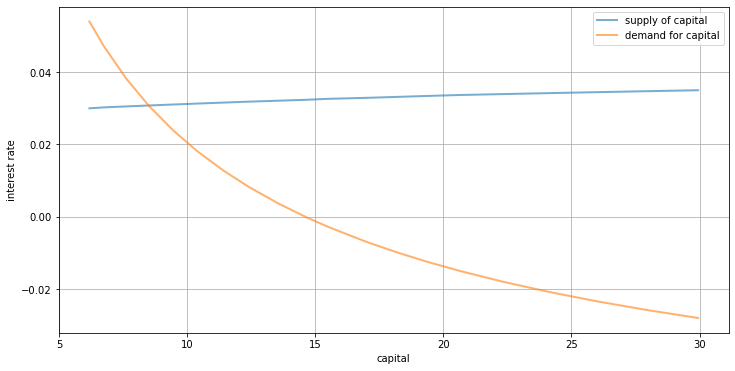

In [6]:
# Plot against demand for capital by firms
fig, ax = plt.subplots()
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, fm.rd(k_vals), lw=2, alpha=0.6, label='demand for capital')
ax.grid()
ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend(loc='upper right')



In [7]:
# Capital ratio from firms
kd = fm.capital_ratio(r_vals)
# Excess demand
ek = kd-k_vals
# Interpolate the excess demand to find the equilibrium r
sp = splrep(r_vals, ek)
fine_r = np.linspace(0.03, 0.035, 200)
fine_ek = splev(fine_r, sp)
# Index for the minimum abs(fine_ek) will give the equilibrium r
r_eq = fine_r[np.argmin(abs(fine_ek))]
# Now we can solve the whole problem for this interest rate
equilibrium = get_equilibrium(hh, fm, r_eq)

a_vals = hh.a_vals
z_vals = hh.z_vals
z_size = hh.z_size
ga = equilibrium['ga']
gc = equilibrium['gc']
gl = equilibrium['gl']
ga_flat = ga.flatten('F') # Flatten optimal policies for MC simulations
gc_flat = gc.flatten('F')
gl_flat = gl.flatten('F')
inv_dist = equilibrium['inv_dist']
K_eq = equilibrium['K']
N_eq = equilibrium['N']
res_eq = equilibrium['res']
output_eq = fm.output(K_eq, N_eq)
w_eq = fm.wage(r_eq)



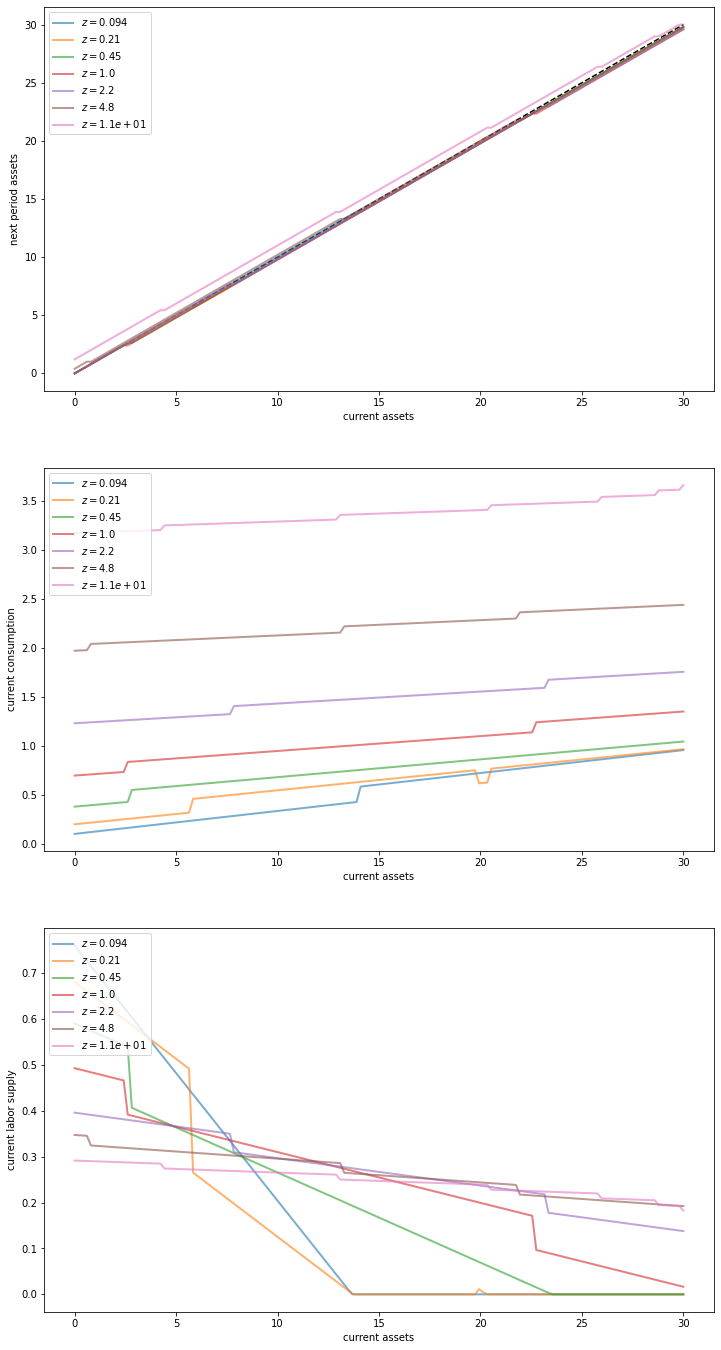

In [8]:
fig, ax = plt.subplots(3,1, figsize=(12, 24))
ax[0].plot(a_vals, a_vals, 'k--')  # 45 degrees
for i in range(z_size):
    lb = f'$z = {z_vals[i]:.2}$'
    ax[0].plot(a_vals, ga[i, :], lw=2, alpha=0.6, label=lb)
    ax[0].set_xlabel('current assets')
    ax[0].set_ylabel('next period assets')
    ax[1].plot(a_vals, gc[i, :], lw=2, alpha=0.6, label=lb)
    ax[1].set_xlabel('current assets')
    ax[1].set_ylabel('current consumption')
    ax[2].plot(a_vals, gl[i, :], lw=2, alpha=0.6, label=lb)
    ax[2].set_xlabel('current assets')
    ax[2].set_ylabel('current labor supply')

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')


  (f) Solve out for the equilibrium allocations and compute statistics for this economy. Report basic statistics about this economy, such as: investment rate, the capitalto-output ratio, cumulative distribution of income (e.g., bottom $1 \%, 5 \%, 10 \%$, $50 \%$, top $1 \%$, top $5 \%$, top $10 \%$ ), cumulative distribution of wealth (e.g., bottom $1 \%, 5 \%, 10 \%, 50 \%$, top $1 \%$, top $5 \%$, top $10 \%$ ), Gini of income and Gini of Wealth.

  From the invariant distribution we get the distributions of economic variables in the stationary equilibrium.
  $$
  \begin{align*}
  I&=\sum_{z}\lambda(z,a)gl(z,a)wz + \sum_{z}\lambda(z,a)ga(z,a)r
  \end{align*}
  $$

In [9]:
# Item f) Simulations
burnin = 100
Nhh = 1000 # Household cross-section
length = 1_000
simul = np.empty((length-burnin, Nhh), dtype='int32')
# Fill with Monte Carlo simulations
for i in range(Nhh):
    simul[:, i] = res_eq.mc.simulate(length)[burnin:]

sim_flat = simul.flatten('F')
# a_dist = a_vals[res_eq.sigma[simul.flatten('F')]]
a_dist = ga_flat[sim_flat]
# Income
labor_i = w_eq*gl_flat[sim_flat]*z_vals[sim_flat % z_size]
cap_i = r_eq*a_dist
total_i = labor_i + cap_i



Text(0.5, 0, 'Wealth')

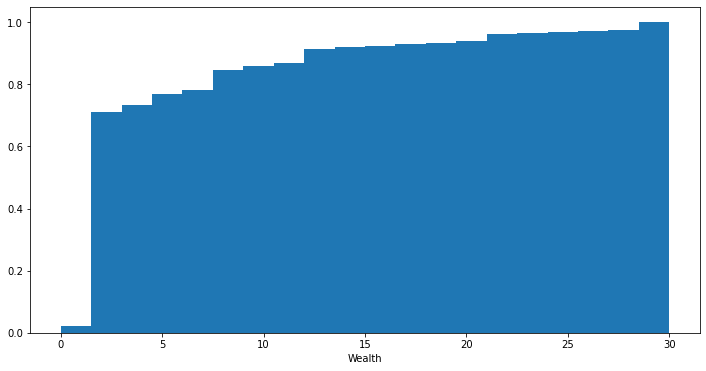

In [10]:
# Plot the histogram
fig, ax = plt.subplots()
ax.hist(a_dist, bins=20, density=True, cumulative=True)
ax.set_xlabel('Wealth')



Text(0.5, 0, 'Income')

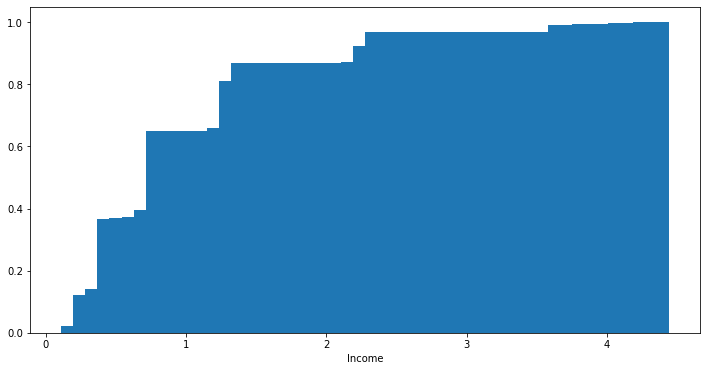

In [11]:
plt.hist(total_i, bins=50, density=True, cumulative=True)
plt.xlabel('Income')



In [12]:
# Quantiles
quantiles = [0.01, 0.05, 0.10, 0.5, 0.90, 0.95, 0.99]
a_q = [np.quantile(a_dist, q) for q in quantiles]
inc_q = [np.quantile(total_i, q) for q in quantiles]
# Gini
@jit(nopython=True)
def gini(x):
    g = np.append(0, np.cumsum(np.sort(x))/np.sum(x))
    gd = np.diff(g)
    area = np.sum((1+np.arange(len(gd)))*gd/len(gd))
    return abs(0.5 - area)/0.5

a_gini = gini(a_dist)
inc_gini = gini(total_i)

print(f"Capital-Output: {K_eq/output_eq}")
print(f"Gini Wealth: {a_gini}")
print(f"Gini Income: {inc_gini}")


Capital-Output: 3.6151686731556145
Gini Wealth: 0.4731319370452476
Gini Income: 0.3940067114590926


  (g) Could you find a value for $\beta$ such the equilibrium interest rate is equal to $4 \%$ per year? Report this value and explain how you found it

  For a given r, the demand for capital is fixed. We only need to create a grid of $\beta$ values and solve the household problem in order to find the amount of capital supplied. Those values must match in equilibrium. We have two options: the bisection method the search for a $\beta$ that equates demand and supply, or interpolate over a gross grid of $\beta$ values and find the one (on a finer grid) that matches supply.

In [13]:
# Bisection method. We know that with a higher value of r, the discount
# must also be higher, thus a lower value of beta is expected.
# We start in the interval 0.88 to 0.96
r1 = 0.04
fm1 = Firm(r = r1)
w1 = fm1.wage(r1)
kd1 = fm1.capital_ratio(r1)

def bisection(func, a, b, tol = 1e-8):
    if func(a)*func(b)>0:
        print('Conditions for the Intermidiate Value Theorem do not hold')
    else:
        # First middle point
        c = (a+b)/2
        error = abs(func(c))
        # ~ print(error) 
        # bisection loop
        while error > tol:
            if func(c)*func(a) < 0:
                b = c
            else:
                a = c
            c = (a+b)/2
            error = abs(func(c))
            # ~ print(error)

    return c

def beta_fun(beta):
    hh = Household(r = r1, w = w1, β = beta)
    ks = get_equilibrium(hh, fm1, r1)['ks']
    # Return the excess supply of capital
    return ks - kd1



In [14]:
# beta_r1 = bisection(beta_fun, 0.88, 0.96, tol=1e-4)


  **Bisection is WAY TOO SLOW!!! Interpolate it.**

In [15]:
beta_vals = np.linspace(0.86, 0.96, 10)
# Excess supply of capital
es = np.array([beta_fun(b) for b in beta_vals])
# Interpolate the excess supply to find beta
sp = splrep(beta_vals, es)
fine_beta = np.linspace(0.86, 0.96, 1000)
fine_es = splev(fine_beta, sp)
# Index for the minimum abs(fine_ek) will give the equilibrium r
beta1 = fine_beta[np.argmin(abs(fine_es))]
print(f"Beta for r=4%: {beta1}")


Beta for r=4%: 0.8919319319319319


  (h) Could you find a value for $\sigma_{z}^{2}$ such the equilibrium wealth Gini in $0.8$ ? Report this value and explain how you found it.

  We basically need to re-estimate the whole model for over a grid of $\sigma_z^2$ and find the one (possibly through interpolation) that yields the desired Gini index.
  A new value for $\sigma_z^2$ will give a new Markov chain for the labor productivity, thus we need to re-estimate the stationary equilibrium for this economy. Once we have the equilibrium prices, we can simulate households and get the stationary distribution of wealth, from which we extract the Gini index. We can do the above steps for many values of $\sigma_z^2$, find the Gini and interpolate them if needed to find Gini = 0.8. Finally, check the just found value for $\sigma_z^2$ ideed yields a Gini index of 0.8.
  This algorithm would take too long to run, so I won't perform it here.

  2. Hopenhayn model. On paying a fixed operating cost $\kappa>0$, an incumbent firm that hires $n$ workers produces flow output $y=z n^{\alpha}$ with $0<\alpha<1$ where $z>0$ is a firm-level productivity level. The productivity of an incumbent firm evolves according to an $\mathrm{AR}(1)$ in $\operatorname{logs}$
  $$
  \ln \left(z_{t+1}\right)=(1-\rho) \ln (\bar{z})+\rho \ln \left(z_{t}\right)+\sigma \epsilon_{t+1}, \rho \in(0,1), \sigma>0
  $$
  where $\epsilon_{t+1} \sim N(0,1)$. Firms discount flow profits according to a constant discount factor $0<\beta<1$. There is an unlimited number of potential entrants. On paying a sunk entry cost $\kappa_{e}>0$, an entrant receives an initial productivity draw $z_{0}>0$ and then starts operating the next period as an incumbent firm. For simplicity, assume that initial productivity $z_{0}$ is drawn from the stationary productivity distribution implied by the AR(1) above.

  Individual firms take the price $p$ of their output as given. Industry-wide demand is given by the $D(p)=\bar{D} / p$ for some constant $\bar{D}>0 .$ Let labor be the numeraire, so that the wage is $w=1 .$ Let $\pi(z)$ and $v(z)$ denote respectively the profit function and value function of a firm with productivity $z .$ Let $v_{e}$ denote the corresponding expected value of an entering firm. Let $\mu(z)$ denote the (stationary) distribution of firms and let $m$ denote the associated measure of entering firms.

  (a) Derive an expression for the profit function.


 The profit function will be given by:

 $$
 \begin{equation}
 \pi_t=pz_t n^{\alpha}-wn-\kappa
 \end{equation}
 $$

 which yield a optimal employment rule, from the first order conditions.

 $$
 \begin{equation}
 n_t=(\alpha p z_t)^{1/1-\alpha}
 \end{equation}
 $$



  (b) Set the parameter values $\alpha=2 / 3, \beta=0.8, \kappa=20, \kappa_{e}=40, \ln (\bar{z})=1.4$, $\sigma=0.20, \rho=0.9$ and $\bar{D}=100 .$ Discretize the AR(1) process to a Markov chain on 33 nodes. Solve the model on this grid of productivity levels. Calculate the equilibrium price $p^{*}$ and measure of entrants $m^{*}$. Let $z^{*}$ denote the cutoff level of productivity below which a firm exits. Calculate the equilibrium $z^{*}$. Plot the stationary distribution of firms and the implied distribution of employment across firms. Explain how these compare to the stationary distribution of productivity levels implies by the AR(1).


In [16]:
"""
Author: Jacob Hess
Modifications: Rafael F. Bressan
Date: October 2021
Description: Replicates Hopenhayn (1992) which finds the stationary equilibrium in a firm dynamics model. I follow the 
algorithm laid out by Gianluca Violante's and Chris Edmond's notes where I solve the incumbant firm problem with value 
function itertation and analytically solve for the stationary distribution. I use Chris Edmond's calibration from his 
example in ch. 3. A slight difference in my code is that I use the rouwenhorst method instead of the tauchen to make 
the continuous tfp process discrete but I still use 20 nodes as in the paper.   
Aknowledgements: I used notes or pieces of code from the following :
    1) Gianluca Violante's notes (https://sites.google.com/a/nyu.edu/glviolante/teaching/quantmacro)
    2) Chris Edmond's notes (http://www.chrisedmond.net/phd2014.html)
    
Required packages: 
    -- Packages from the anaconda distribution. (to install for free: https://www.anaconda.com/products/individual)
    -- QuantEcon (to install: 'conda install quantecon')
"""


class Hopenhayn:
    
    """
    Class object of the model. Hopenhayn().solve_model() runs everything
    """

    ############
    # 1. setup #
    ############

    def __init__(self, 
                beta=0.8,             #discount factor 5 year
                alpha=2/3,            #labor share
                cf=20,                #fixed cost 
                ce=40,                #entry cost
                D_bar = 100,              #size of the market (exogeneous)
                wage = 1,             #wage, normalized to one
                rho_z = 0.9,          #autocorrelation coefficient
                sigma_z = 0.2,        #std. dev. of shocks
                Nz = 33,              #number of discrete income states
                z_bar = 1.4,          #constant term in continuous income process (not the mean of the process)
                pmin = 0.5,             # Min price to search for equilibrium
                pmax = 100,             # Max price to search for equilibrium
                plott =1,              #select 1 to make plots
                ):
        
        #parameters subject to changes
        self.beta, self.alpha, self.cf, self.ce, self.D_bar, self.wage, self.rho_z  = beta, alpha, cf, ce, D_bar, wage, rho_z
        self.sigma_z, self.Nz, self.z_bar, self.plott = sigma_z, Nz, z_bar, plott 
        # price equilibrium
        self.pmin, self.pmax = pmin, pmax
        
        self.setup_parameters()
        self.setup_grid()
    
    def setup_parameters(self):
        
        # a. incumbent firm soluton  
        self.tol = 1e-8          #difference tolerance
        self.maxit = 4000        #maximum value function iterations
        
    def setup_grid(self):
        
        # a. discretely approximate the continuous tfp process 
        # self.mc = qe.markov.approximation.rouwenhorst(self.Nz, self.z_bar, self.sigma_z, self.rho_z)
        self.mc = qe.markov.approximation.tauchen(self.rho_z, self.sigma_z, (1-self.rho_z)*self.z_bar, 3, self.Nz)

        # b. transition matrix and states
        self.pi = self.mc.P
        self.grid_z = np.exp(self.mc.state_values)
        
        # c. initial productivity distribution for entrant firm
        
        # there is no explicit assumption on the distribution in hopenhayn or edmond's notes.
        # I use the stationary distribution of the transition matrix. I provide an alternative
        # unfirom distribution. The results are very similar.
        
        self.nu = np.array(self.mc.stationary_distributions)
        # self.nu = (1/self.Nz)*np.ones(self.Nz)        #uniform distribution
        
        #the object mc returns nu as a 1d matrix. I convert this to a 1d array for the calcuations later.
        self.nu=np.squeeze(np.asarray(self.nu))
        
        # Using the defined tauchen method from above
        # self.grid_z, self.pi, self.nu = tauchen(self.rho_z, self.z_bar, self.sigma_z**2*(1-self.rho_z**2), self.Nz, 3)
    
    
    ####################################
    # 2. Helper functions #
    ####################################
    
    
    
    def interpol(self,x,y,x1):
       
       """
       1-D linear interpolation.
       
       *Input
           - x : x-coordinates to evaluate on
           - y : y-coordinates of data points
           - x1 : x-coordinates of points to interpolate
       *Output
           - y1 : interpolated value y-coordinate
           - i : grid index on the right of x1.
       """
       
       N = len(x)
       i = np.minimum(np.maximum(np.searchsorted(x,x1,side='right'),1),N-1)
       xl = x[i-1]
       xr = x[i]
       yl = y[i-1]
       yr = y[i]
       y1 = yl + (yr-yl)/(xr-xl) * (x1-xl)
       above = x1 > x[-1]
       below = x1 < x[0]
       y1 = np.where(above,y[-1] +   (x1 - x[-1]) * (y[-1]-y[-2])/(x[-1]-x[-2]), y1)
       y1 = np.where(below,y[0],y1)
   
       return y1, i
    


    ################################################
    # 3. Solve incumbent and entrant firm problem #
    ###############################################
    
    def static_profit_max(self, price):
        """
        Static incumbent firm profit maximzation.
        """
        
        # a. given prices, find the labor hiring decision policy function (analytical expression derived in 
        #violante's notes pg. 2)
        pol_n = ((self.alpha * price * self.grid_z) / self.wage) ** (1 / (1 - self.alpha))
        
        # b. given prices and hiring decision, find firm output
        firm_output = self.grid_z * (pol_n ** self.alpha)
        
        # c. given prices and hiring decision, find profits by solving static firm problem
        firm_profit = price*firm_output - self.wage*pol_n - self.cf
        
        return firm_profit, firm_output, pol_n
    
    def incumbent_firm(self, price):
        """
        Value function iteration for the incumbent firm problem.
        """ 

        # a. initialize 
        VF_old = np.zeros(self.Nz)
        VF = np.zeros(self.Nz)
        
        # b. solve the static firm problem
        firm_profit, firm_output, pol_n = self.static_profit_max(price)
    
        # c. given prices and hiring decision, iterate on incumbent firm vf
        for it in range(self.maxit):
            
            VF = firm_profit + self.beta * np.dot(self.pi, VF_old).clip(min=0)
            dist = np.abs(VF_old - VF).max()
        
            if dist < self.tol :
               break
           
            VF_old = np.copy(VF)

        # d. enter/stay in the market policy function 
        EVF = np.dot(self.pi, VF)
        pol_enter = np.ones(self.Nz)*(EVF >= 0)
        
        # e. productivity exit threshold
        idx = np.argmax(pol_enter) #index of self.pol_enter closest to one on the left
        exit_cutoff = self.grid_z[idx - 1]
        
        # f. alternative way to do steps d and e
        #avg_VF = np.dot(self.pi, VF)
        #idx = np.searchsorted(avg_VF, 0) #index of avg_VF closest to zero on the left
        
        #exit_cutoff = self.grid_z[idx]
        #pol_exit = np.where(self.grid_z < exit_cutoff, 1, 0)
        #pol_enter = 1 - pol_exit

        return VF, firm_profit, firm_output, pol_n, pol_enter, exit_cutoff
    
    
    
    ####################################
    # 4. Find stationary equilibrium  #
    ###################################
    
    
    def find_equilibrium_price(self):
        """
        Finds the equilibrium price that clears markets. 
        
        The function follows steps 1-3 in algorithm using the bisection method. It guesses a price, solves incumbent firm vf 
        then checks whether free entry condition is satisfied. If not, updates the price and tries again. The free entry condition 
        is where the firm value of the entrant (VF_entrant) equals the cost of entry (ce) and hence the difference between the two is zero. 
        """
        
        # a. initial price interval
        pmin, pmax = self.pmin, self.pmax
        
        # b. iterate to find prices
        for it_p in range(self.maxit):
            
            # i. guess a price
            price = (pmin+pmax)/2
            
            # ii. incumbent firm value function
            VF, firm_profit, firm_output, pol_n, pol_enter, exit_cutoff = self.incumbent_firm(price)
        
            # iii. entrant firm value function
            VF_entrant = self.beta * np.dot(VF, self.nu)
            
            # iv. check if free entry condition is satisfied
            diff = np.abs(VF_entrant-self.ce)
            
            if diff < self.tol:
                break
            
            # v. update price interval
            if VF_entrant < self.ce :
                pmin=price 
            else:
                pmax=price
        
        return price, VF, firm_profit, firm_output, pol_n, pol_enter, exit_cutoff
            
    
    def solve_invariant_distribution(self, m, maxit = 4_000):
        #pi_tilde = (self.pi * pol_enter.reshape(self.Nz, 1)).T
        #I = np.eye(self.Nz)
        # Iterate to get the invariant distribution
        inv_dist = np.ones(self.Nz)/self.Nz
        incumb_dist = (self.pi*self.pol_enter[:, None])
        for i in range(maxit):
            inv_dist1 = inv_dist @ incumb_dist + m*self.nu
            
            if np.abs(la.norm(inv_dist1) - la.norm(inv_dist)) < self.tol:
                break
            
            inv_dist = inv_dist1.copy()
        
        # Another try with a nested for loop
        # inv_dist0 = np.ones(self.Nz)/self.Nz
        # for i in range(maxit):
        #     inv_dist = self.inv_dist_fun(m, inv_dist0)
        #     if abs(la.norm(inv_dist)-la.norm(inv_dist0)) < self.tol:
        #         break
        #     inv_dist0 = inv_dist.copy()
            
        return inv_dist1
        # return m * ( np.dot(la.inv(I - pi_tilde), self.nu ) )
    
    def inv_dist_fun(self, m, inv_dist0):
        incumb_dist = (self.pi*self.pol_enter[:, None])
        inv_dist = np.zeros(self.Nz)
        for z1 in range(self.Nz):
            aux = 0
            for z in range(self.Nz):
                aux = aux + incumb_dist[z, z1]*inv_dist0[z]
            inv_dist[z1] = aux + m*self.nu[z1]
            
        return inv_dist
            
    def solve_m(self, pricess, m_min = 0, m_max = 0.5):
        demand = self.D_bar / pricess
        a = self.alpha
        z = self.grid_z
        firm_output = (a*pricess)**(a/(1-a))*(z)**(1/(1-a))
        for i in range(self.maxit):
            m = (m_min+m_max)/2
            inv_dist = self.solve_invariant_distribution(m)
            output = (z*firm_output*inv_dist).sum()
            if output > demand:
                m_max = m
            else:
                m_min = m
            excess = output - demand
            # print(f"m Iteration {i}, m: {m}")
            # print(f"Output: {output}, demand: {demand}")
            if abs(excess) < self.tol:
                break
            
        self.m_star = m
        self.distrib_stationary = inv_dist
        return m, inv_dist
        
    #####################
    # 5. Main function #
    ####################
    
    def solve_model(self):
        """
        Finds the stationary equilibrium
        """  
        
        t0 = time.time()    #start the clock
        
        # a. Find the optimal price using bisection (algo steps 1-4)
        self.price_ss, self.VF, self.firm_profit, self.firm_output, self.pol_n, self.pol_enter, self.exit_cutoff = self.find_equilibrium_price()
        
        # c. Invariant (productivity) distribution with endogenous exit. Here assume m0=1 which will come in handy in the next step.
        # self.distrib_stationary_0 = self.solve_invariant_distribution(1, self.pol_enter)
        
        # d. Rather than iterating on market clearing condition to find the equilibrium mass of entrants (m_star)
        # we can compute it analytically (Edmond's notes ch. 3 pg. 25)
        # demand = self.D_bar / self.price_ss
        # self.m_star = demand/( np.dot( self.distrib_stationary_0, self.firm_output) )
                
        # e. Rescale to get invariant (productivity) distribution (mass of plants)
        # self.distrib_stationary = self.m_star * self.distrib_stationary_0
        # ALTERNATIVE: Iterate over m to find inv_dist and m
        self.solve_m(self.price_ss)
        self.total_mass = np.sum(self.distrib_stationary)
        
        # Invariant (productivity) distribution by percent. mu(z)
        self.pdf_stationary = self.distrib_stationary / self.total_mass
        self.cdf_stationary = np.cumsum(self.pdf_stationary)
        
        # f. calculate employment distributions
        self.distrib_emp = (self.pol_n * self.distrib_stationary)
        
        # invariant employment distribution by percent
        self.pdf_emp = self.distrib_emp / np.sum(self.distrib_emp)
        self.cdf_emp = np.cumsum(self.pdf_emp)
        
        # g. calculate statistics
        self.total_employment = np.dot(self.pol_n, self.distrib_stationary)
        self.average_firm_size = self.total_employment / self.total_mass
        self.exit_rate = self.m_star / self.total_mass
        #self.exit_rate = 1-(np.sum(self.pi.T*self.distrib_stationary_0*self.pol_enter)/np.sum(self.distrib_stationary_0)) #alternative calculation
        
        # h. plot
        
        if self.plott:
            plt.plot(self.grid_z, self.VF)
            plt.axvline(self.exit_cutoff, color='tab:red', linestyle='--', alpha=0.7)
            plt.axhline(0, color='tab:green', linestyle='--', alpha=0.7)
            plt.title('Incumbant Firm Value Function')
            plt.legend(['Value Function', 'Exit Threshold='+str(self.exit_cutoff.round(2)),'VF <= 0'])
            plt.xlabel('Productivity level')
            #plt.savefig('value_func_hopehayn.pdf')
            plt.show()
            
            plt.plot(self.grid_z, self.pdf_stationary)
            plt.plot(self.grid_z, self.nu)
            plt.title('Stationary distribution: z versus firm productivity')
            plt.xlabel('Productivity')
            plt.ylabel('Density')
            plt.show()
            
            plt.plot(self.pol_n, self.pdf_stationary)
            plt.title('Firm size distribution')
            plt.xlabel('Employment')
            plt.ylabel('Density')
            plt.show()
         
            # plt.plot(self.grid_z,self.cdf_stationary)
            # plt.plot(self.grid_z, self.cdf_emp)
            # plt.title('Stationary CDF' )
            # plt.xlabel('Productivity level')
            # plt.ylabel('Cumulative Sum')
            # plt.legend(['Firm Productivity','Employment'])
            # #plt.savefig('cdf_hopehayn.pdf')
            # plt.show()
            
            #employment share pie charts 
            employed = [20, 50, 100, 500]
            
            #percentage of firms that employ employed
            self.share_firms = np.zeros(len(employed)+1)
            for i in range(len(employed)):
                summ = np.sum(self.share_firms)
                interpolate = self.interpol(self.pol_n, self.cdf_stationary, employed[i])[0]
                self.share_firms[i] = interpolate - summ
            self.share_firms[-1] = 1 - np.sum(self.share_firms)
            
            plt.pie(self.share_firms, labels=['<20','21<50','51<100','101<500','501<'], autopct="%.1f%%")
            plt.title('Size of Firms by Number of Employees')
            #plt.savefig('firm_size_hopehayn.pdf')
            plt.show()
            
            self.share_employment = np.zeros(len(employed)+1)
            
            for i in range(len(employed)):
                summ = np.sum(self.share_employment)
                interpolate = self.interpol(self.pol_n, self.cdf_emp, employed[i])[0]
                self.share_employment[i] = interpolate - summ
            self.share_employment[-1] = 1 - np.sum(self.share_employment)
            
            plt.pie(self.share_employment, labels=['<20','21<50','51<100','101<500','501<'], autopct="%.1f%%")
            plt.title('Employment Share by Firm Size')
            #plt.savefig('employment_by_firm_size_hopehayn.pdf')
            plt.show()
            
            #these pie charts show that most firms are small, few large firms. In the second it says most people 
            #are employed by large firms
        
        print("\n-----------------------------------------")
        print("Stationary Equilibrium")
        print("-----------------------------------------")
        print(f"Price  = {self.price_ss:.5f}")
        print(f"Measure of entrants = {self.m_star:.5f}")
        print(f"Exit cutoff = {self.exit_cutoff:.5f}")
        print(f"entry/exit rate = {self.exit_rate:.5f}")
        print(f"avg. firm size = {self.average_firm_size:.2f}")
        
        t1 = time.time()
        print(f'\nTotal Run Time: {t1-t0:.2f} seconds')



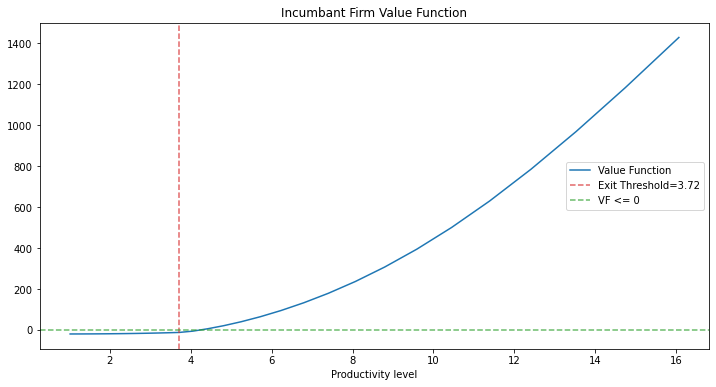

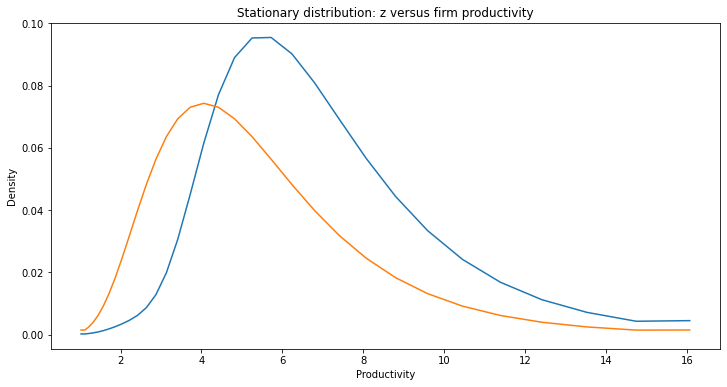

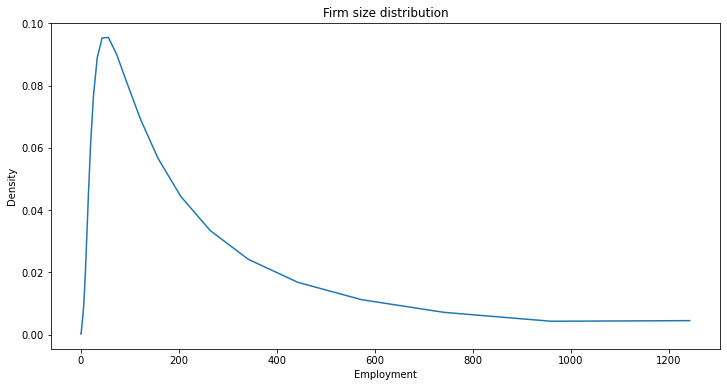

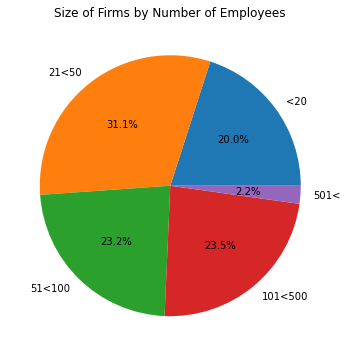

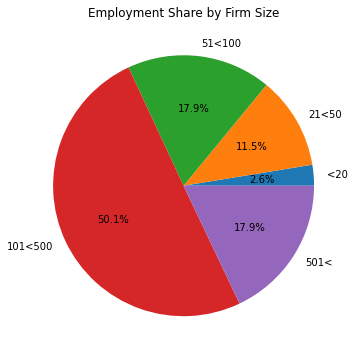


-----------------------------------------
Stationary Equilibrium
-----------------------------------------
Price  = 1.00414
Measure of entrants = 0.00976
Exit cutoff = 3.72091
entry/exit rate = 0.13903
avg. firm size = 103.69

Total Run Time: 1.11 seconds


In [17]:
hop = Hopenhayn(plott=True)
hop.solve_model()


  (c) Now suppose the demand curve shifts, with $\bar{D}$ increasing to $120 .$ How does this change the equilibrium price and measure of entrants? How does this change the stationary distributions of firms and employment? Give intuition for your results.

In [18]:
hop2 = Hopenhayn(D_bar=120, plott=False)
hop2.solve_model()




-----------------------------------------
Stationary Equilibrium
-----------------------------------------
Price  = 1.00414
Measure of entrants = 0.01171
Exit cutoff = 3.72091
entry/exit rate = 0.13903
avg. firm size = 103.69

Total Run Time: 0.30 seconds


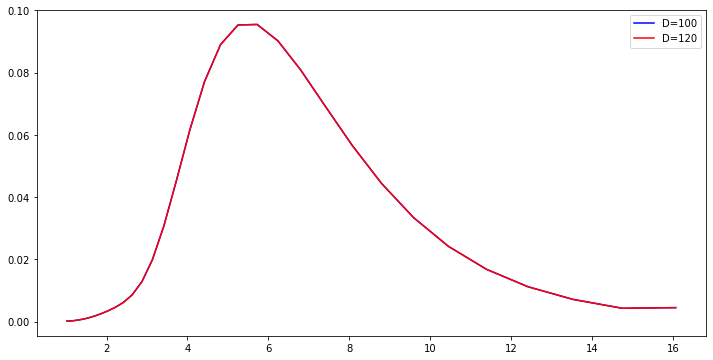

In [19]:
z = hop.grid_z
fig, ax = plt.subplots()
ax.plot(z, hop.pdf_stationary, color = 'blue', label = 'D=100')
ax.plot(z, hop2.pdf_stationary, color='red', label='D=120')
ax.legend()



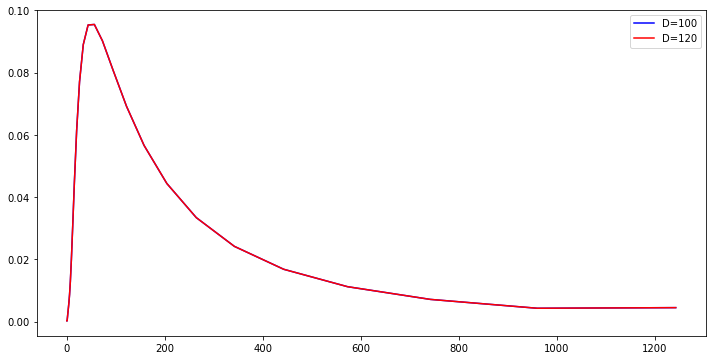

In [20]:
fig, ax = plt.subplots()
ax.plot(hop.pol_n, hop2.pdf_stationary, color = 'blue', label = 'D=100')
ax.plot(hop2.pol_n, hop2.pdf_stationary, color='red', label='D=120')
ax.legend()


 The equilibrium price does not change. The increased demand reflects in the mass of entrant firms and competition forces price back down. Since price is the same, so are the distributions for firms productivities and employment.

 # 3. Ramsey model in continuous time.

 Consider the decentralised Ramsey model in continuous time. Households solve
  $$
  \max _{c, l} \int_{0}^{\infty} e^{-\rho t} u(c, l) d t
  $$
  subject to
  $$
  \dot{a}=w(1-l)+r a-c
  $$
  where $c$ is consumption, $a$ denotes assets and $l$ is leisure. $\rho$ is the subjective discount rate, $r$ is the interest rate and $w$ is the wage rate. Firms rent capital and labour from households to maximise
  $$
  \max A K^{\alpha} N^{1-\alpha}-w N-(r+\delta) K
  $$
  where $\delta$ is the depreciation rate and $A$ is a productivity factor.

  (a) Write down the HJB associated with the households problem. Explain the steps to derive it.

 We start from the discrete time problem.

 $$
 \begin{align*}
 V(a_t)&=\max_{c_t, l_t}\{u(c_t, l_t)+(1-\rho)V(a_{t+1})\}\\
 s.t. : a_{t+1}&=w(1-l_t)+(1+r)a_t-c_t
 \end{align*}
 $$

 Then, setting the period of time to $\Delta$.

 $$
 \begin{align*}
 V\left(a_{t}\right)&=\max _{\left(c, a_{i+a}\right)}\left\{\Delta u(c, l)+(1-\Delta \rho) V\left(a_{t+\Delta}\right)\right\}\\
 a_{t+\Delta}&=\Delta\left[w_{t}\left(1-l_{t}\right)+r a_{t}-c_{t}\right]+a_{t}
 \end{align*}
 $$

 Subtracting $V\left(a_{t}\right)$ from both sides and substituting the resources constraint into $V(a_{t+\Delta})$, we have

 $$
 \begin{equation*}
 0=\max _{\left\{c_t, l_t\right\}}\left\{\Delta u(c_t, l_t)+(1-\Delta \rho) V\left(\Delta\left[w_{t}\left(1-l_{t}\right)+r a_{t}-c_{t}\right]+a_{t}\right)\right\}-V\left(a_{t}\right) \\
 \end{equation*}
 $$

 Dividing both sides by $\Delta$ and considering $h:=\Delta[w_{t}(1-$ $\left.l_{t}\right)+r a_{t}-c_{t}]$ we obtain


 $$
 \begin{equation*}
 0=\max _{\left\{c_{t}, l_t\right\}}\left\{u(c, l)+\frac{V\left(a_{t}+h\right)-V\left(a_{t}\right)}{h}[w_t(1-l_t)+ra_t-c_t]\right\}-\rho V\left(a_{t+\Delta}\right)
 \end{equation*}
 $$

 Notice that $\Delta \rightarrow 0 \implies h\rightarrow 0$, thus:

 $$
 \begin{equation}
 \rho V(a)=\max \left\{u(c, l)+V'(a)(w(1-l)+r a-c)\right\}
 \end{equation}
 $$


  **From now on, assume that $u(c, l)=\log (c)+\eta \log (l)$. You can assume that $\rho=0.04$ and $\eta=0.75$**

  (b) For a given interest rate $r$ and wage rate $w$, write down a code to solve the households problem.


 The FOC conditions will be:

 $$
 \begin{align*}
 u_c(c,l)&=V'(a)\\
 u_l(c,l)&=wV'(a)
 \end{align*}
 $$

 combining them and substituting the given utility equation we get:

 $$
 \begin{align}
 c^*&=\frac{w+ra}{1+\eta}\\
 l^*&=\eta c^* / w
 \end{align}
 $$

 The Households problem will yield solutions $c^*(a;w,r)$ and $l^*(a;w,r)$.


  (c) Write down the market clearing conditions.
  Assume that $\delta=0.06, A=1$ and $\alpha=0.33$.


 $$
 \begin{align*}
 a&=K\\
 1-l&=N\\
 \dot{a}+c&=F(K,N)
 \end{align*}
 $$

 Solving the above equations we arrive at the following market clearing equations:
 $$
 \begin{align}
 a&=(1-l)k\\
 \dot{a}+c&=A(1-l)^{1-\alpha}a^{\alpha}
 \end{align}
 $$


  (d) Write down the equations that describe the steady-state of the system and solve for the steady-state level of capital and labour supply.


 From the firm maximization problem we have expressions for $r$ and $w$.
 $$
 \begin{align*}
 r&=\alpha A k^{\alpha-1}-\delta\\
 w&=(1-\alpha)Ak^\alpha
 \end{align*}
 $$
 Therefore, capital-labor ratio is fully determined by interest rate:
 $$
 \begin{equation*}
 k=\left(\frac{r+\delta}{\alpha A}\right)^{1/\alpha-1}
 \end{equation*}
 $$
 Solving the Hamiltonian from the HH problem, we know the interest rate in equilibrium is given by:
 $$
 \begin{equation}
 r_{ss}=\rho
\end{equation}
 $$
 This in turn, pins down the value for $k_{ss}$ only in terms of model parameters. And so does $w_{ss}$
 $$
 \begin{align}
 k_{ss}&=\left(\frac{\rho+\delta}{\alpha A}\right)^{1/\alpha-1}\\
 w_{ss}&=(1-\alpha)Ak_{ss}^\alpha
 \end{align}
 $$

 Moreover, steady-state implies that capital acumulation is zero, $\dot{a}=0$, thus $c_{ss}=w_{ss}(1-l)+r_{ss}a$, given the market clearing conditions we can compute $c_{ss}/(1-l_{ss})=w_{ss}+r_{ss}k_{ss}$, and from the HH FOC, $l_{ss}=\eta c_{ss}/w_{ss}$. Solving these equations for $l_{ss}$:
 $$
 \begin{align}
 l_{ss}&=\frac{\eta(w_{ss}+r_{ss}k_{ss})/w_{ss}}{1+\eta(w_{ss}+r_{ss}k_{ss})/w_{ss}}\\
 c_{ss}&=(1-l_{ss})(w_{ss}+r_{ss}k_{ss})\\
 a_{ss}&=k_{ss}(1-l_{ss})
 \end{align}
 $$

In [21]:
from scipy.optimize import fsolve
from scipy.optimize import bisect
def solve_ss(r):
    k = ((r+delta)/(alpha)*A)**(1/(alpha-1))
    w = (1-alpha)*A*k**alpha
    num = eta*(w+r*k)/w
    l = num/(1+num)
    c = (1-l)*(w+r*k)
    a = k*(1-l)
    # Check savings in SS
    # adot = w*(1-l)+r*a-c
    # print(f"savings: {adot}")
    
    return c, l, a

def production(grida):
    return A*grida**alpha*(1-lss)**(1-alpha)

def utility(c, l):
    cb = np.fmax(tol, c)
    lb = np.clip(l, tol, 1-tol)
    return np.log(cb)+eta*np.log(lb)
    
def solve_l(c, a):
    def obj_fun(l, c, a):
        rhs = eta*c/((1-alpha)*A*a**alpha)
        lhs = l/((1-l)**alpha)
        return lhs - rhs
    # Bisection
    # lres = np.zeros(Na)
    # for i in range(Na):
    #     # print(f'RHS: {eta*c[i]/((1-alpha)*A*a[i]**alpha)}')
    #     # print(f'LHS1: {0.999999/((1-0.999999)**alpha)}')
    #     lres[i] = bisect(obj_fun, 0, 0.99999999999999, args=(c[i], a[i]))
      
    # Root
    res = root(obj_fun, np.ones(Na)*lss, args=(c, a),)  
    # return lres
    return res.x



In [22]:
# Set Parameters
eta=0.75
A = 1
alpha = 0.33
delta=0.06
rho = 0.04
# Na = 100
maxit = 1_000
tol = 1e-6


In [23]:
# For rho = 4%
css, lss, ass = solve_ss(0.04)
print("Steady state levels")
print(f"Consumption: {css}")
print(f"Labor: {1-lss}")
print(f"Assets: {ass}")


Steady state levels
Consumption: 0.7608871844787667
Labor: 0.526936688950059
Assets: 3.1308325545884417


In [24]:
# Get SS values
css, lss, ass = solve_ss(rho)
# Setup grids
# grida = np.linspace(0.1*ass, 2*ass, Na)
# da = grida[1]-grida[0]
da = ass/100
grida = np.arange(0, 2*ass, da)[1:]
ssidx = np.argmax(grida == ass)
Na = len(grida)
dV = np.zeros(Na)
dVb = np.zeros(Na)
dVf = np.zeros(Na)
c = np.zeros(Na)
l = np.zeros(Na)


In [25]:
# Initial guess for V0 assumes consumption of whole production and lss
V0 = production(grida)
dist = []
# Solve HH problem
for i in range(maxit):
    V = V0.copy()
    # forward difference
    dVf[0:Na-1] = (V[1:Na]-V[0:Na-1])/da
    dVf[Na-1] =  (A*(1-lss)**(1-alpha)*grida[Na-1]**alpha) #will never be used
    # backward difference
    dVb[1:Na] = (V[1:Na]-V[0:Na-1])/da
    dVb[0] = (A*(1-lss)**(1-alpha)*grida[0]**alpha) #will never be used
    
    I_concave = dVb > dVf  #indicator whether value function is concave (problems arise if this is not the case)
    
    #consumption, leisure and savings with forward difference
    cf = np.clip(dVf**(-1), tol, 99)
    lf = np.clip(solve_l(cf, grida), tol, 1-tol)
    # lf = np.ones(Na)*lss
    muf = A*(1-lf)**(1-alpha)*grida**alpha - cf
    #consumption, leisure and savings with backward difference
    cb = np.clip(dVb**(-1), tol, 99)
    lb = np.clip(solve_l(cb, grida), tol, 1-tol)
    # lb = np.ones(Na)*lss
    mub = A*(1-lb)**(1-alpha)*grida**alpha - cb
    #consumption and derivative of value function at steady state
    c0 = css #*np.ones(Na) 
    dV0 = c0**(-1)
    
    # dV_upwind makes a choice of forward or backward differences based on
    # the sign of the drift    
    If = muf > 0 #below steady state
    Ib = mub < 0 #above steady state
    I0 = (1-If-Ib) #at steady state
    #make sure the right approximations are used at the boundaries
    Ib[0] = 0
    If[0] = 1
    Ib[Na-1] = 1
    If[Na-1] = 0
    # dV_Upwind = dVf*If + dVb*Ib + dV0*I0 #important to include third term
    dV_Upwind = (dVf + dVb)/2
    dV_Upwind[ssidx] = dV0
    c = np.clip(dV_Upwind**(-1), tol, 99)
    l = np.clip(solve_l(c, grida), tol, 1-tol)
    # l = np.ones(Na)*lss
    Vchange = utility(c, l)+dV_Upwind*(A*(1-l)**(1-alpha)*grida**alpha - c)-rho*V
        
    ## This is the update
    # the following CFL condition seems to work well in practice
    # Delta = .9*da/np.max(A*(1-l)**(1-alpha)*grida**alpha)
    Delta = 0.01
    V0 = V0 + Delta*Vchange
    
    dist.append(np.max(np.abs(Vchange)))
    if dist[i] < tol:
        print('Value Function Converged, Iteration = %5.0f' % i)
        break    

/tmp/ipykernel_36155/1547961022.py:27: RuntimeWarning: invalid value encountered in power
  lhs = l/((1-l)**alpha)


In [26]:
# Savings
sav = A*(1-l)**(1-alpha)*grida**alpha - c

Text(0, 0.5, '$||V^{n+1} - V^n||$')

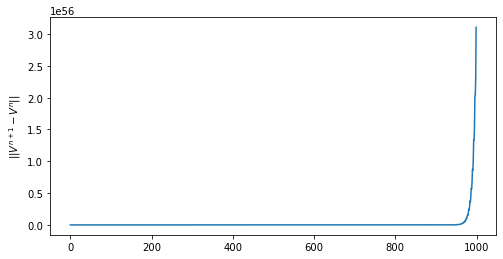

In [27]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(dist)
ax.set_ylabel('$||V^{n+1} - V^n||$')


Text(0.5, 0, 'Assets')

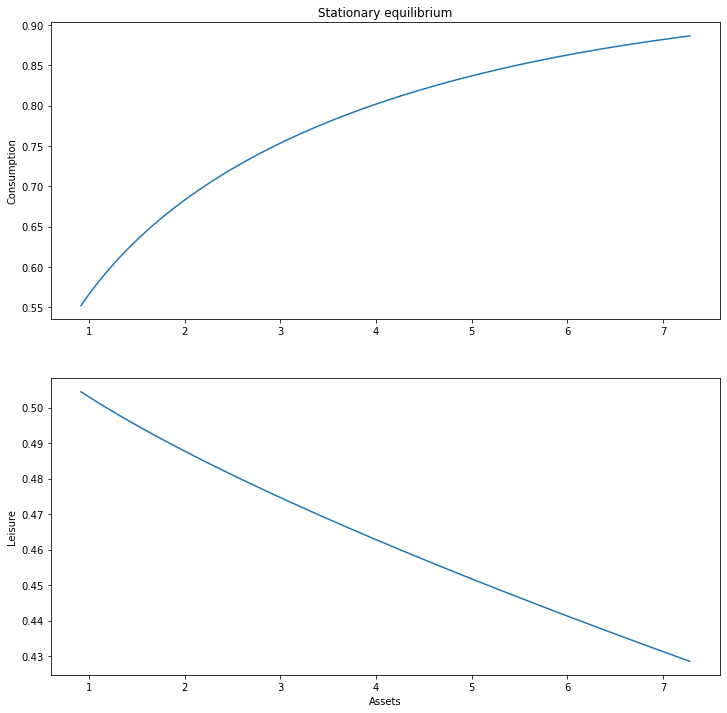

In [28]:
# Stationary Equilibrium for several values of r
rse = np.linspace(0, 0.8, 1000)
cse = np.zeros(Na)
lse = cse.copy() 
ase = lse.copy()
for i in range(Na):
    cse[i], lse[i], ase[i] = solve_ss(rse[i])

fig, ax = plt.subplots(2,1, figsize=(12, 12))
ax[0].plot(ase, cse)
ax[0].set_ylabel('Consumption')
ax[0].set_title('Stationary equilibrium')
ax[1].plot(ase, lse)
ax[1].set_ylabel('Leisure')
ax[1].set_xlabel('Assets')

Text(0, 0.5, 'Savings')

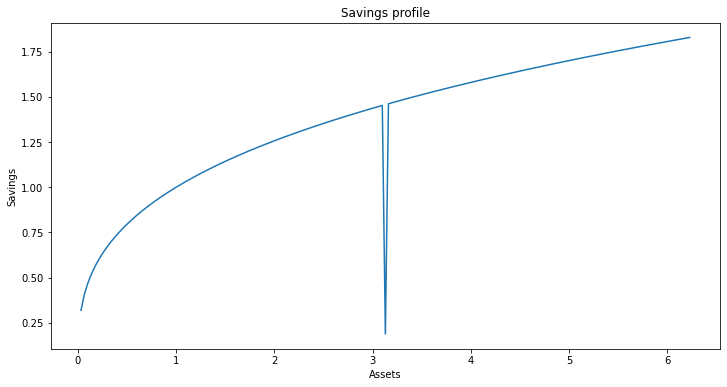

In [29]:
plt.plot(grida, sav)
plt.title('Savings profile')
plt.xlabel('Assets')
plt.ylabel('Savings')

Clearly the above solution is not converging properly. I could not find (just yet) a way to solve this issue.


  (e) Write down a code to solve out the whole transition. Then simulate a permanent change in the TFP factor, such that $A$ increases from $A=1$ to $A=1.2$. Plot the evolution of capital, labour and consumption.

 Although I could not implement the endogenous labor supply version of this problem, I run the simplified version where labor is supplied inelastically.

In [30]:
class Ramsey_cont():
    
    def __init__(self,rho,delta,A,alpha,eta,grida):
        self.rho = rho
        self.delta = delta
        self.A = A
        self.alpha = alpha
        self.grida = grida
        self.eta = eta
    
    def compute_gridw(self, w = 0, exog = False):
        gridw = np.ones(self.grida.size)
        if exog == False:
            for i in np.arange(self.grida.size):
                gridw[i] = self.A*(1-self.alpha)*self.grida[i]**(alpha)
        else:
            gridw = gridw*w
        
        self.gridw = gridw
        
        return gridw
                
    def compute_gridr(self,r = 0,exog = False):
        gridr = np.ones(self.grida.size)
        if exog == False:
            for i in np.arange(self.grida.size):
                gridr[i] =  self.A*self.alpha*self.grida[i]**(self.alpha-1) - self.delta
        else:
            gridr = gridr*r
        
        self.gridr = gridr
        
        return gridr
    
    def compute_V(self,V):
        N = self.grida.size
        TV = np.ones(N)
        dV = np.ones((3,N))
        dV_upwind = np.ones(N)
        policy_c = np.ones((2,N))
        savings = np.ones((2,N))
        css = np.ones(N)
        policy_final = np.ones(N)
        Ib = np.ones(N)
        If = np.ones(N)
        Iss = np.ones(N)
        
        #Calculando dV
        da = self.grida[1]-self.grida[0]
        
        for i in range(1,N):
            dV[0,i] = (V[i]-V[i-1])/da #backwards
        dV[0,0] = 1
        
        for i in range(0,N-1):
            dV[1,i] = (V[i+1]-V[i])/da #foward
        dV[1,N-1] = 1 
        
        for i in range(N):
            css[i] = self.A*self.grida[i]**self.alpha - self.delta*self.grida[i] 
            dV[2,i] = css[i]**(-1) #'steady state'
            
            
        #Calculando TV
        for i in np.arange(N):
            policy_c[0,i] = dV[0,i]**(-1) #backwards
            policy_c[1,i] = dV[1,i]**(-1) #foward
            savings[0,i] = self.grida[i]*self.gridr[i] + self.gridw[i] - policy_c[0,i] #backwards
            savings[1,i] = self.grida[i]*self.gridr[i] + self.gridw[i] - policy_c[1,i] #foward
            
            Ib[i] = 0
            If[i] = 0
            if savings[0,i] < 0:
                Ib[i] = 1
            if savings[1,i] > 0:
                If[i] = 1
            
            Ib[0] = 0
            If[0] = 1
            Ib[N-1] = 1
            If[N-1] = 0
            Iss[i] = 1 - If[i] - Ib[i]
            dV_upwind[i] = Ib[i]*dV[0,i] + If[i]*dV[1,i] + Iss[i]*dV[2,i]
                
            policy_final[i] = dV_upwind[i]**(-1)
            U = np.log(policy_final[i])
            TV[i] = (U + dV_upwind[i]*(self.grida[i]*self.gridr[i] + self.gridw[i] - policy_final[i]))/self.rho
        
        return TV, policy_final
    
    def solve_model(self,update = 0.05,w = 0, r = 0, exog = False,tol = 1e-4, showing = False):
        #Computando w e r
        self.compute_gridr(r, exog)
        self.compute_gridw(w, exog)
        
        V_old = (np.log(self.A*self.grida**self.alpha))/self.rho 
        check = tol + 1
        i = 0
        
        while check > tol:
            V_new, policy_c = self.compute_V(V_old)
            check = np.max(np.abs(V_new - V_old))
            
            if showing == True:
                show = [i,check]
                print(show)
            
            i = i + 1
            #updating slowly
            V_old = update*V_new + (1-update)*V_old
            
        self.V = V_new
        self.policy_c = policy_c
        
        return V_new, policy_c
    
    def transition(self,a0_pos,T_shock,T,policy_1,policy_2,savings_1,savings_2):
        c = np.ones(T)
        a = np.ones(T)
        s = np.ones(T)
        
        a[0] = self.grida[a0_pos]
        c[0] = policy_1[a0_pos]
        s[0] = savings_1[a0_pos]
        #s[0] = self.grida[0]*self.gridr[0] + self.gridw[0] - c[0]
        
        for t1 in range(1,T_shock):
            a[t1] = a[t1-1] + s[t1-1]
            aux = np.abs(np.ones(self.grida.size)*a[t1] - self.grida)
            a_index = int(np.argmin(aux))
            c[t1] = policy_1[a_index]
            s[t1] = savings_1[a_index]
            #s[t1] = self.grida[a_index]*self.gridr[a_index] + self.gridw[a_index] - c[t1]
        
        for t2 in range(T_shock,T):
            a[t2] = a[t2-1] + s[t2-1]
            aux = np.abs(np.ones(self.grida.size)*a[t2] - self.grida)
            a_index = int(np.argmin(aux))
            c[t2] = policy_2[a_index]
            s[t2] = savings_2[a_index]
            #s[t2] = self.grida[a_index]*self.gridr[a_index] + self.gridw[a_index] - c[t2]
            
        
        return c,a,s
        

In [31]:
# Parameters 
rho = 0.04
delta = 0.06
A = 1
alpha = 0.33
eta = 0.75

# Computing steady state
ass = (A*alpha/(delta + rho))**(1/(1-alpha))
upper = 2 *ass
lower = 0.01**ass
n = 400
grida = np.linspace(lower,upper,n)

Text(0.5, 0, 'assets')

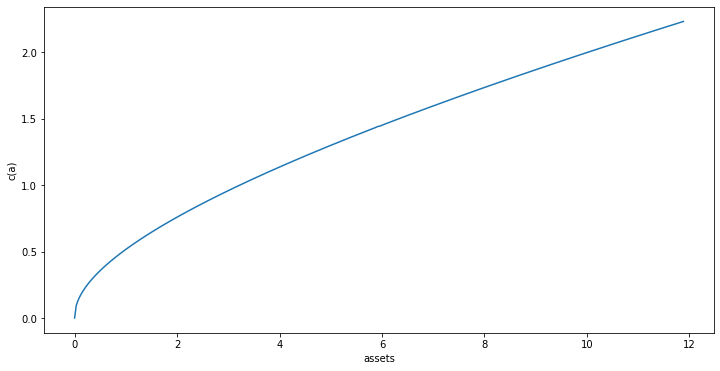

In [32]:
#Item b
r = 0.02
w = 1.5
model = Ramsey_cont(rho, delta, A, alpha, eta, grida)
V_b, policy_b = model.solve_model(0.001, w, r)
savings_b = model.grida*model.gridr + model.gridw - policy_b
#Plotting
fig, ax = plt.subplots()
ax.plot(grida, policy_b)
ax.set_ylabel('c(a)')
ax.set_xlabel('assets')

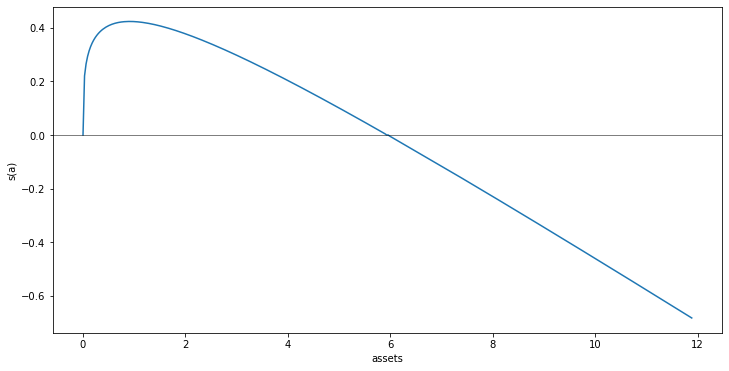

In [33]:

#Savings
fig = plt.figure()
graf = fig.add_subplot()
graf.plot(model.grida,savings_b)
graf.set_ylabel('s(a)')
graf.set_xlabel('assets')
graf.axhline(y=0, color = 'black',linewidth = 0.5)

In [34]:
#Item e
A = 1
modelo = Ramsey_cont(rho, delta, A, alpha,eta, grida)
V_low, policy_c_low = modelo.solve_model(update = 0.001)
savings_low = modelo.grida*modelo.gridr + modelo.gridw - policy_c_low
A = 1.2
modelo = Ramsey_cont(rho, delta, A, alpha,eta, grida)
V_high, policy_c_high = modelo.solve_model(update = 0.001)
savings_high = modelo.grida*modelo.gridr + modelo.gridw - policy_c_high

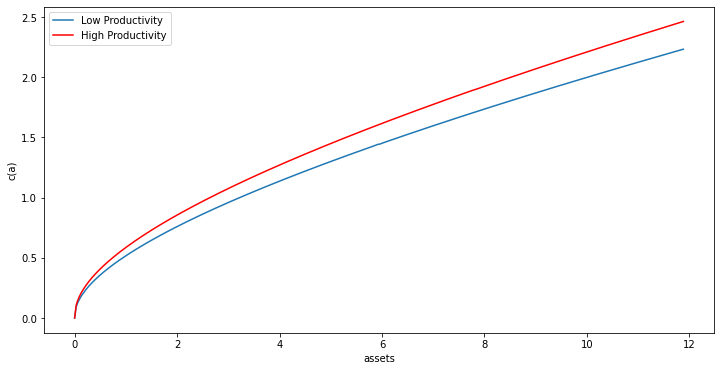

In [35]:
#Policy functions
fig, ax = plt.subplots()
ax.plot(grida, policy_c_low, label='Low Productivity')
ax.plot(grida, policy_c_high, color = 'r', label='High Productivity')
ax.set_ylabel('c(a)')
ax.set_xlabel('assets')
ax.legend()

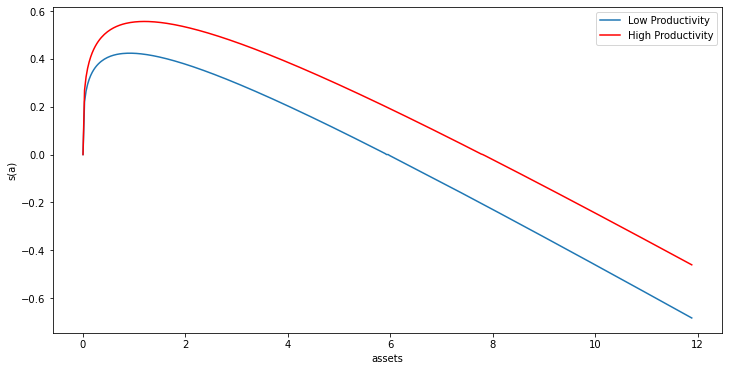

In [36]:
fig, ax = plt.subplots()
ax.plot(grida, savings_low, label='Low Productivity')
ax.plot(grida, savings_high, color = 'r', label='High Productivity')
ax.set_ylabel('s(a)')
ax.set_xlabel('assets')
ax.legend()


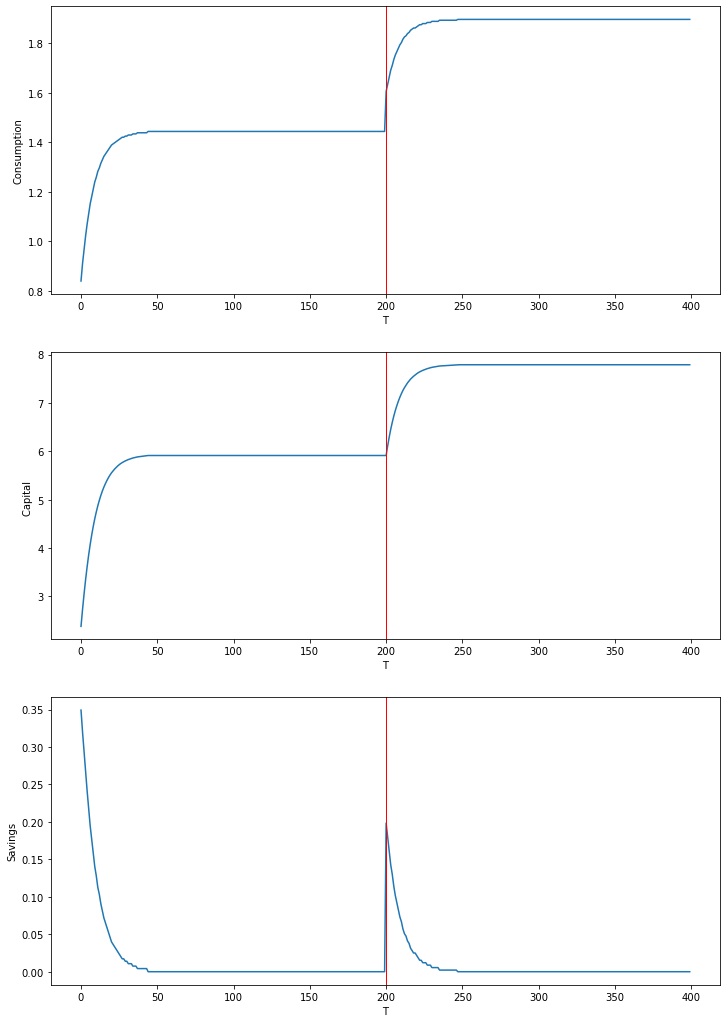

In [37]:
# Solving the transition 
a0 = 80
T_shock = 200
T = 400
consumo, assets, savings = modelo.transition(a0, T_shock, T, policy_c_low, policy_c_high, savings_low, savings_high)

variables = [consumo,assets,savings]
labels = ['Consumption','Capital ','Savings']
fig, ax = plt.subplots(3, 1, figsize=(12, 18))
for i in np.arange(len(variables)):
    ax[i].plot(np.arange(T), variables[i])
    ax[i].axvline(x=T_shock, color = 'r',linewidth = 1)
    ax[i].set_ylabel(labels[i])
    ax[i].set_xlabel('T')